# FCE Evaluations
Apoorva Havanur, ahavanur <br/>
Judy Zhang, judyz

Each semester CMU students are asked by the Registrar's office to fill out evaluations of the classes they took that semester. The Faculty Course Evaluations (FCEs) are used extensively by faculty to gauge overall satisfaction as well as for important decisions such as faculty promotions. For students, FCEs are an invaluable resource for providing feedback on courses, as well as planning out which courses to take in the future. 

In our final project, we take a look at FCE data, which has been collected since 2008, and use it to answer several questions about courses at CMU. Specifically, the questions we hope to answer are:

1. What is the relationship between the score students give to their instructors across different metrics (like "Demonstrate importance of subject material") and the overall score they give the course?
2. How does a professor's years of experience correlate with their teaching rating?
3. How does the average rating of courses vary from department to department? From level to level (i.e 100 level classes vs 200 level)
4. How does time spent on a course correlate with satisfaction with the course / other metrics reported?
5. How do students respond differently to multiple professors teaching the same course vs one professor?

## Data Processing
We download the FCE data from here: https://wwwp3.smartevals.com/reporting/StudentsSeeResults.aspx and exported to CSV.  

In [1]:
import csv
import pandas as pd
import math
import numpy as np
from scipy import stats
# Use svg backend for better quality
import matplotlib
# AUTOLAB_IGNORE_START
matplotlib.use("svg")
# AUTOLAB_IGNORE_STOP
import matplotlib.pyplot as plt
# AUTOLAB_IGNORE_START
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) # you should adjust this to fit your screen
# AUTOLAB_IGNORE_STOP

After reading in the data, we do a bit of processing to remove some empty columns, and change the course number values to make it easier to process later on in our analysis. We also filter out the statistically insignificant rows by taking out rows where the number of possible respondents is less than 10 and the response rate is 20% or less, i.e the small classes that had very few people give responses, and therefore are not statistically significant. 

In [2]:
df = pd.read_csv("table.csv")
df = df.drop(['Hrs Per Week 5', 'Hrs Per Week 8'], axis=1)
df = df[pd.notnull(df['Num'])]
temp = []
for item in df["Num"]:
    temp.append(item.replace("-",""))
df["Num"] = temp
df = df[df.Num.apply(lambda x: x.isnumeric())]
df["Num"] = df["Num"].astype("int64")
df = df[df["Possible Respondents"] > 10]
df = df[df["Response Rate %"] > 20]

print(df.shape)
df.head()

(24695, 21)


,Year,Semester,Dept,Num,Section,Name,Course Name,Level,Possible Respondents,Num Respondents,...,Hrs Per Week,Interest in student learning,Clearly explain course requirements,Clear learning objectives & goals,Instructor provides feedback to students to improve,Demonstrate importance of subject matter,Explains subject matter of course,Show respect for all students,Overall teaching rate,Overall course rate
1,2018,Spring,ARC,48733,A3,"KARAGUZEL, OMER",ENV PERF SIM,Graduate,12,9,...,8.00,4.56,4.67,4.67,4.44,4.89,4.67,4.89,4.67,4.44
2,2018,Spring,ART,60131,C3,"BINGHAM, ROBERT",3D MEDIA STUDIO II,Undergraduate,14,4,...,10.25,5.00,3.50,4.00,5.00,4.50,4.50,5.00,4.75,4.50
3,2018,Spring,ART,60131,D3,"GURYSH, STEVEN",3D MEDIA STUDIO II,Undergraduate,13,3,...,8.00,5.00,5.00,5.00,4.67,5.00,4.67,5.00,5.00,4.67
4,2018,Spring,ART,60131,A3,"SCARPONE, PHILLIP",3D MEDIA STUDIO II,Undergraduate,12,5,...,12.20,4.80,4.80,4.80,4.80,4.80,5.00,4.60,4.80,4.80
11,2018,Spring,CHE,6462,A3,"GOUNARIS, CHRYSANTHOS",OPTM MDG & ALGRTHMS,Undergraduate,86,23,...,7.87,4.57,4.22,4.35,3.91,4.30,4.13,4.57,4.22,4.04


To make our lives easier, we also write a wrapper plotting function that will allow us to easily segment the data into different subsets and let us look at relationships between different features. 

slope: 0.9858702164801676
intercept: -0.18773759339096507
r_value: 0.8337821446846334
p_value: 0.0
std_error: 0.010052592143918827


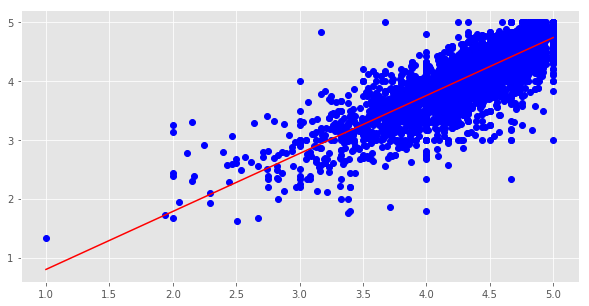

In [5]:
def plot_against_overall(category, df, dept=None, course_level=None, overall_category="Overall course rate"):
    """
    Inputs: category (string), category of interest in the dataframe
            df (pandas.dataframe), dataframe
            dept (string), major department
            course_level (int), 100,200,300... level of difficulty
            overall_category (string), overall course rate or overall teaching rate
    
    Output: matplotlib graph of category vs overall
            returns nothing
    """
    given = []
    overall = []
    if dept != None:
        df = df[df["Dept"]==dept]
    if course_level != None:
        level = course_level//100
#         for item in df['Num']:
#             if not str(type(item)) == "<class 'numpy.int64'>":
#                 #print(str(type(item)))
        df = df[(df['Num']//100)%10 == level]
    for i,row in df.iterrows():
        item = row[category]
        total = row[overall_category]
        if pd.notnull(item) and pd.notnull(total):
            given.append(item)
            overall.append(total)
    x = given
    y = overall
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    print("slope:", slope)
    print("intercept:", intercept)
    print("r_value:", r_value)
    print("p_value:", p_value)
    print("std_error:", std_err)
    mn=np.min(x)
    mx=np.max(x)
    x1=np.linspace(mn,mx,500)
    y1=slope*x1+intercept
    plt.plot(x,y, 'ob')
    plt.plot(x1,y1,'-r')
    return 
p = plot_against_overall("Interest in student learning", df, None, 100)
plt.show()

## Comparing Categories Against Overall Satisfaction

We then look at the categories presented in the FCE survey and plot their ratings against overall course rate and overall teaching rate. These categories include a professor's interest in student learning, ability to clearly explain course requirements, ability to present clear learning objectives and goals, feedback to students for improvement, ability to explain subject matter of the course, and show respect fo all students.

slope: 1.02415043841631
intercept: -0.3328781290715268
r_value: 0.838977271386451
p_value: 0.0
std_error: 0.004502316972443879


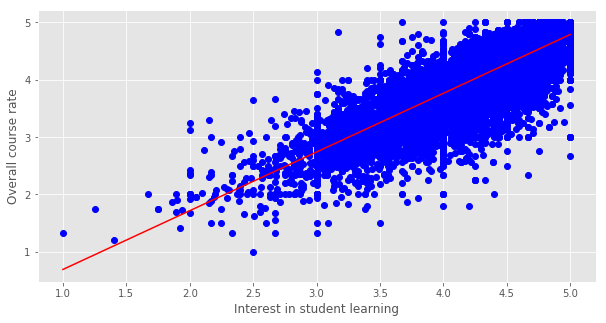

slope: 1.0773943737097484
intercept: -0.4901400507826219
r_value: 0.8891089105714975
p_value: 0.0
std_error: 0.00375921595477231


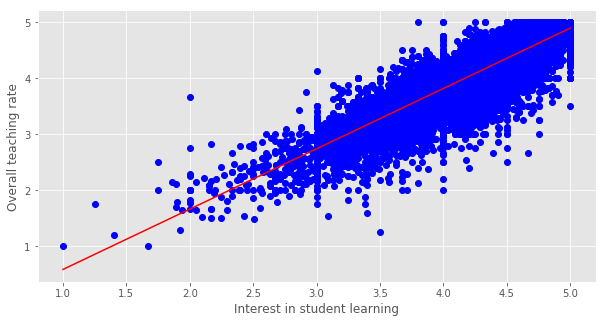

slope: 0.8872371464515556
intercept: 0.40573493516096626
r_value: 0.8422954363962688
p_value: 0.0
std_error: 0.0038482898292884404


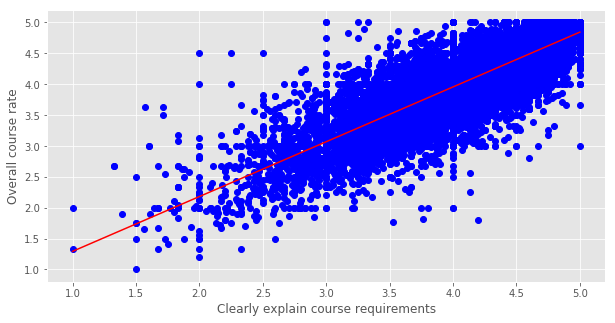

slope: 0.904126918654045
intercept: 0.41018175336665985
r_value: 0.8646592901777554
p_value: 0.0
std_error: 0.0035604022649759226


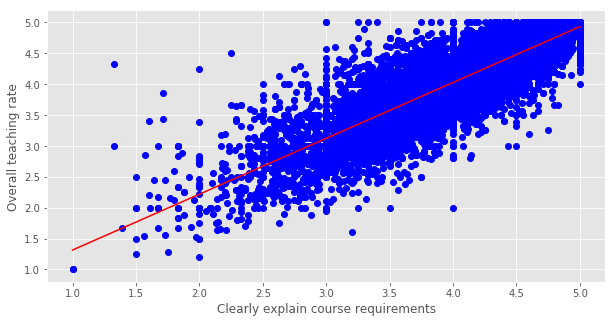

slope: 0.9625281251779233
intercept: 0.05810441984289927
r_value: 0.8748831708990691
p_value: 0.0
std_error: 0.00361159523686841


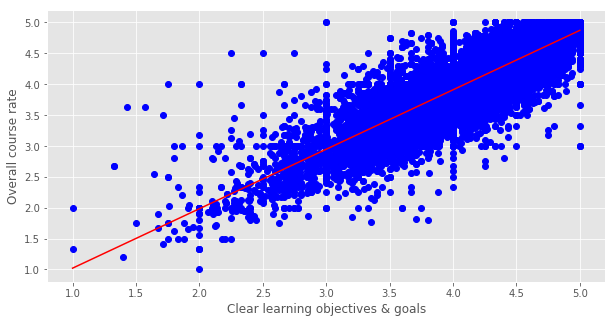

slope: 0.9768165817830244
intercept: 0.07307730850436123
r_value: 0.8944177843083435
p_value: 0.0
std_error: 0.00331059896950127


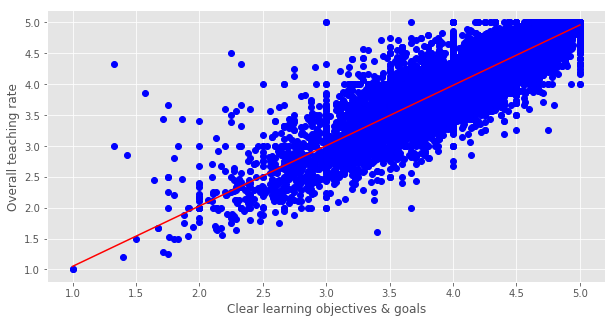

slope: 0.8222326472167923
intercept: 0.7730806240267265
r_value: 0.834745762809754
p_value: 0.0
std_error: 0.003676169077977243


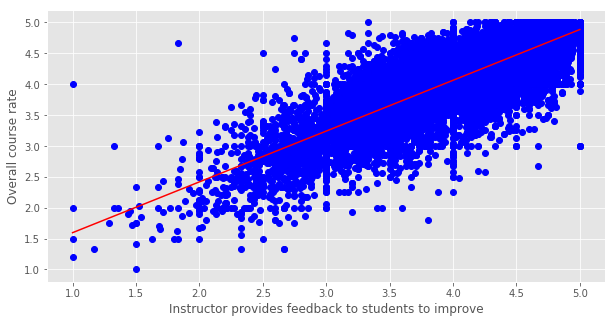

slope: 0.8520722667112861
intercept: 0.7262938891481818
r_value: 0.8714125570590855
p_value: 0.0
std_error: 0.0032511527705338756


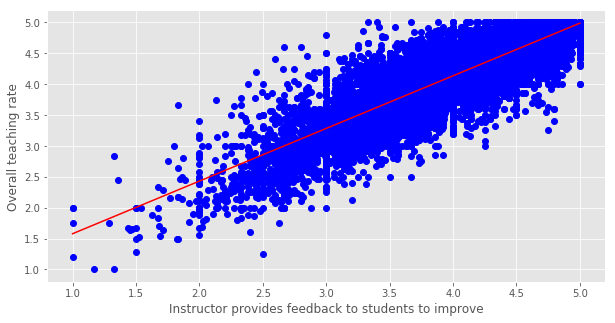

slope: 0.9495559701025338
intercept: 0.11096136897257125
r_value: 0.8983404490216328
p_value: 0.0
std_error: 0.0031472518230833205


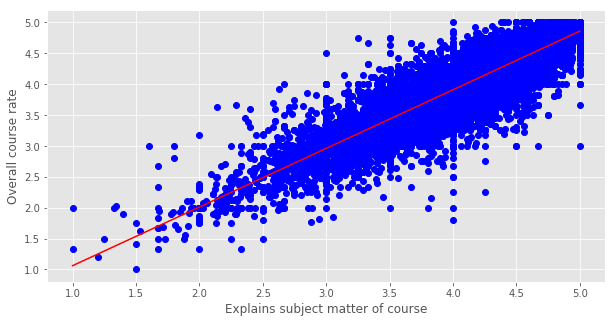

slope: 0.9835319554401797
intercept: 0.04220343154173989
r_value: 0.9373490438456803
p_value: 0.0
std_error: 0.0024777394387635776


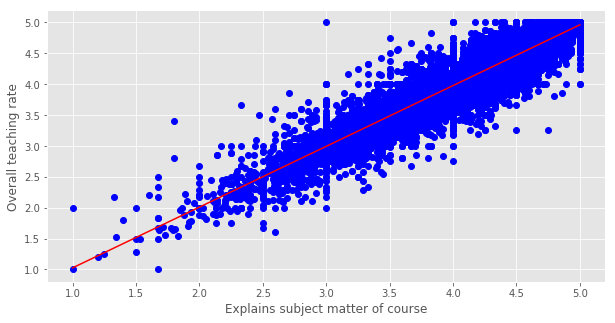

slope: 0.9225996685211904
intercept: -0.018101865032718933
r_value: 0.7094772989973012
p_value: 0.0
std_error: 0.006211367586936479


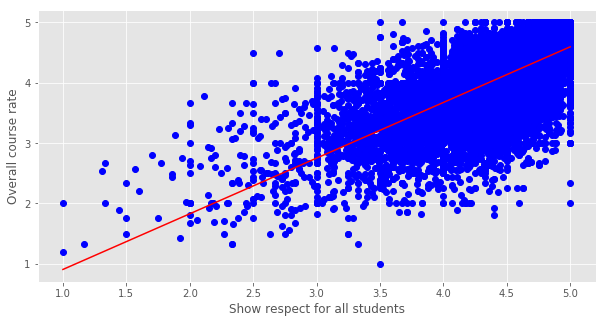

slope: 0.9960913165500437
intercept: -0.27436398857578226
r_value: 0.7714685718878307
p_value: 0.0
std_error: 0.005568283258846037


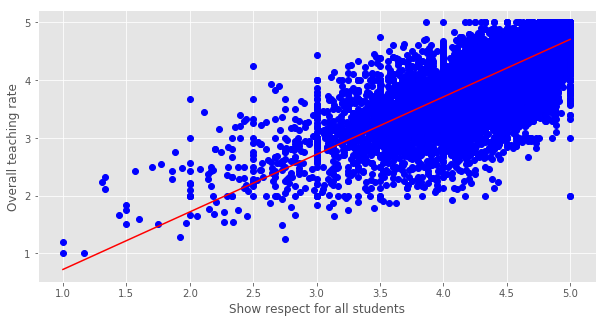

In [6]:
categories = ['Interest in student learning', 'Clearly explain course requirements', 'Clear learning objectives & goals', 'Instructor provides feedback to students to improve', 'Explains subject matter of course', 'Show respect for all students']  
overall = ["Overall course rate", "Overall teaching rate"]
for cat in categories:
    for ov in overall:
        p = plot_against_overall(category = cat, df = df, dept=None, course_level=None, overall_category=ov)
        plt.xlabel(cat)
        plt.ylabel(ov)
        plt.show()

The category with the weakest correlation to overall course rate and teaching rate is 'show respect for all students'. However, showing respect for students is more strongly correlated with teaching rate than overall course rate, suggesting that while it is important for professors to show respect to their students when it comes to how students view their professors, students do not really consider it as highly when considering the course itself. 

## By Department

While it is interesting to know about CMU overall, we are also interested in seeing distinctions between different departments across the university.

In [7]:
all_departments = list(set(df['Dept']))
len(all_departments)

60

There are 60 unique departments at CMU. We're interested in knowing for which departments are FCE scores the highest and lowest. 

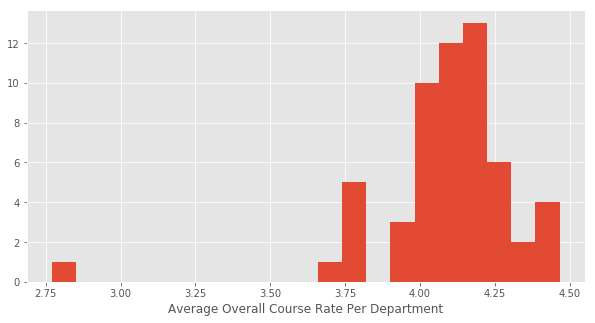

In [8]:
course_rate_by_dept = []
depts = []
for dept in all_departments:
    subset = df[df['Dept'] == dept]
    if subset.shape[0] < 5: #we skip departments with few courses being rated
        continue
    avg_course_rate = subset['Overall course rate'].mean()
    course_rate_by_dept.append(avg_course_rate)
    depts.append(dept)
course_rate_by_dept = np.array(course_rate_by_dept)
plt.hist(course_rate_by_dept, bins='auto')
plt.xlabel("Average Overall Course Rate Per Department")
plt.show()

From the histogram above, we see that the average overall course rate within each department seems to be somewhat nromally distributed around 4.1, with a clear outlier around 2.8 and small spikes near 3.75 and 4.4. We now want to isolate the departments that are part of the top 10% and bottom 10% by overall course rate. 

In [9]:
lowest = np.array(depts)[course_rate_by_dept <= np.percentile(course_rate_by_dept, 10)]
lowest

array(['MCS', 'CRM', 'CIT', 'ECO', 'IS', 'WC'], dtype='<U3')

The lowest rated departments are CRM (Creative Enterprises), IS (Information Systems), MCS (Mellon College of Science), CIT (College of Engineering), WC (unclear, program ended in 2009), and ECO (Economics). It's important to note here that MCS and CIT are listed as departments that house the general education programs for both of these schools, and do not offer much in terms of variety. Interestingly enough, two departments (IS and ECO) are the home departments of the two authors of this notebook.   

Mean Course Rate: 3.757


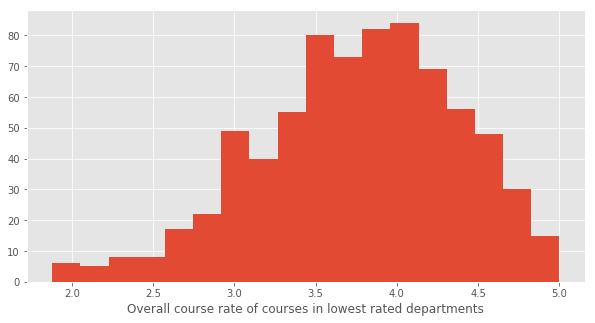

Mean Teaching Rate: 3.886


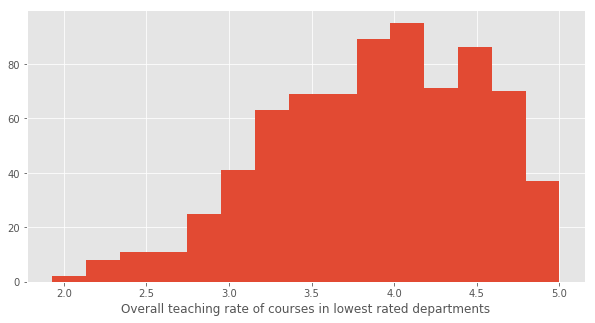

In [10]:
lowest_df = df[df['Dept'].isin(lowest)]
print("Mean Course Rate: " + str(round(lowest_df['Overall course rate'].mean(),3)))
plt.hist(lowest_df['Overall course rate'], bins='auto')
plt.xlabel("Overall course rate of courses in lowest rated departments")
plt.show()
print("Mean Teaching Rate: " + str(round(lowest_df['Overall teaching rate'].mean(),3)))
plt.hist(lowest_df['Overall teaching rate'], bins='auto')
plt.xlabel('Overall teaching rate of courses in lowest rated departments')
plt.show()

From the distributions above, we see that amongst the courses in the most poorly rated departments at CMU, the scores are much more normally distributed, with both the course rate mean and teaching mean around 3.8.  

We can also run a similar analysis for the highest rated departments. 

In [11]:
highest = np.array(depts)[course_rate_by_dept >= np.percentile(course_rate_by_dept, 90)]
highest #all graduate departments!

array(['ETC', 'HIS', 'ICT', 'ISR', 'ML', 'IA'], dtype='<U3')

In [12]:
df[df['Dept']=='ISR'].tail()

,Year,Semester,Dept,Num,Section,Name,Course Name,Level,Possible Respondents,Num Respondents,...,Hrs Per Week,Interest in student learning,Clearly explain course requirements,Clear learning objectives & goals,Instructor provides feedback to students to improve,Demonstrate importance of subject matter,Explains subject matter of course,Show respect for all students,Overall teaching rate,Overall course rate
40298,2009,Fall,ISR,8741,A,"TOMASIC, ANTHONY",VERY LG INFO SYSTEMS,Graduate,12,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,4.13
41924,2009,Spring,ISR,8764,A3,"EPPINGER, JEFFREY",WEB APPLICATNS DEVLP,Graduate,30,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.83,4.75
41926,2009,Spring,ISR,8781,A3,"SADEH, NORMAN",MBL PRVSV CMPTNG SRV,Graduate,26,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.38,4.25
43589,2008,Spring,ISR,8764,A3,"EPPINGER, JEFFREY",WEB APPLICATNS DEVLP,Graduate,15,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.50,4.33
43591,2008,Spring,ISR,8781,A3,"SADEH, NORMAN",MBL PRVSV CMPTNG SRV,Graduate,15,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.40,2.80


The highest rated departments are ML (Machine Learning), HIS (History, no longer a department since 2008), IA (Graduate Business Administration), ICT (Information and Communications Technology),  ISR (Institute for Software Research) and ETC (Entertainment Technology Center). Interestingly enough, of all the current departments in this group, all of them are graduate departments. 

Mean Course Rate: 4.393


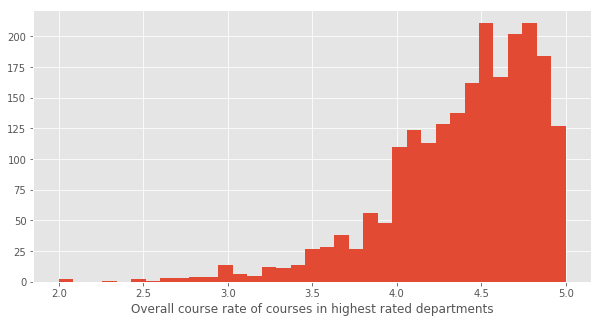

Mean Teaching Rate: 4.473


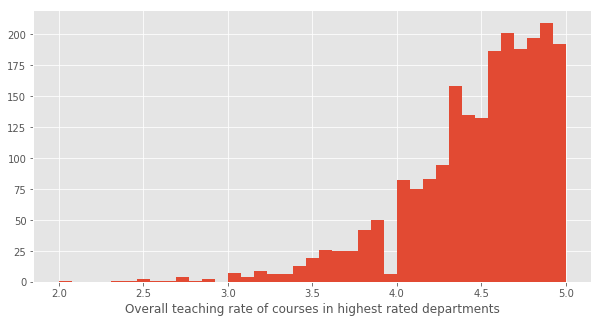

In [13]:
highest_df = df[df['Dept'].isin(highest)]
print("Mean Course Rate: " + str(round(highest_df['Overall course rate'].mean(),3)))
plt.hist(highest_df['Overall course rate'], bins='auto')
plt.xlabel("Overall course rate of courses in highest rated departments")
plt.show()
print("Mean Teaching Rate: " + str(round(highest_df['Overall teaching rate'].mean(),3)))
plt.hist(highest_df['Overall teaching rate'], bins='auto')
plt.xlabel('Overall teaching rate of courses in highest rated departments')
plt.show()

The overall teaching rate and course rate for courses in these departments is much more skewed towards 5's as compared to the lowest rated departments. Indeed, the average is around 4.4 for both teaching and course rate. 

slope: 0.894047591968
intercept: 0.104837473183
r_value: 0.830536935422
p_value: 1.28397475759e-167
std_error: 0.0234983824835


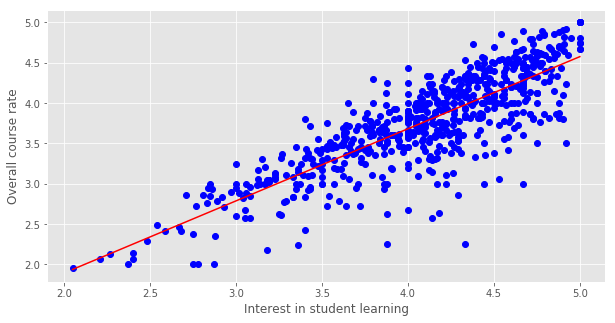

slope: 0.991362072124
intercept: -0.16219762844
r_value: 0.899549104662
p_value: 2.38513455913e-236
std_error: 0.0188677058983


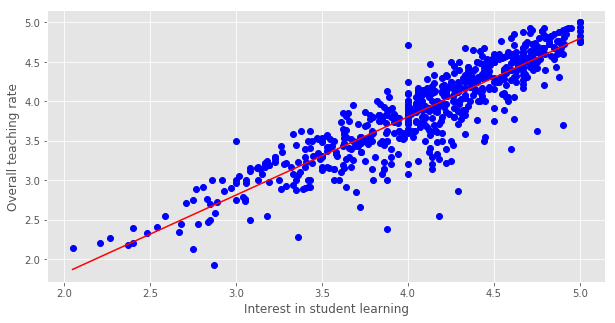

slope: 0.940379503672
intercept: 0.0303229806571
r_value: 0.86302042695
p_value: 3.13353066869e-195
std_error: 0.0215738819372


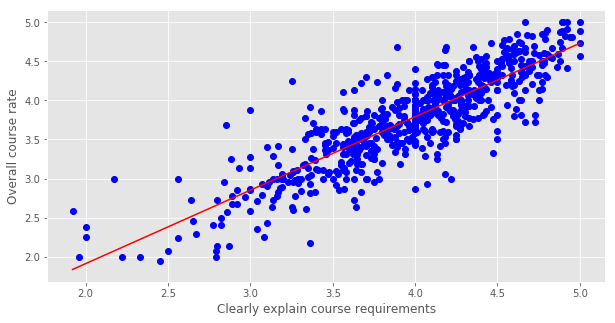

slope: 0.990644122723
intercept: -0.038000213919
r_value: 0.888034525063
p_value: 7.31965834031e-222
std_error: 0.0201022352703


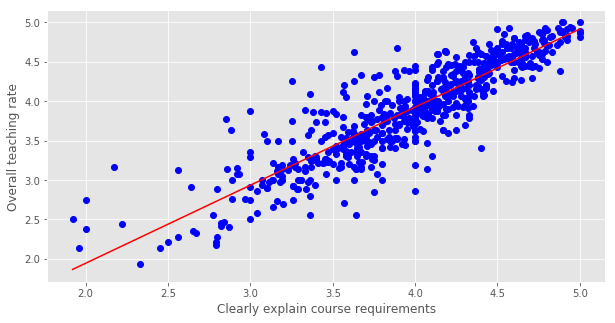

slope: 0.988611149695
intercept: -0.17097962439
r_value: 0.893985205168
p_value: 3.85790349466e-229
std_error: 0.01942120659


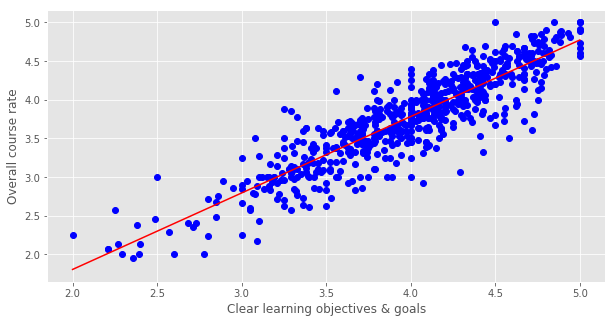

slope: 1.0421326006
intercept: -0.252764405706
r_value: 0.92049635314
p_value: 7.2096768345e-268
std_error: 0.0173384665138


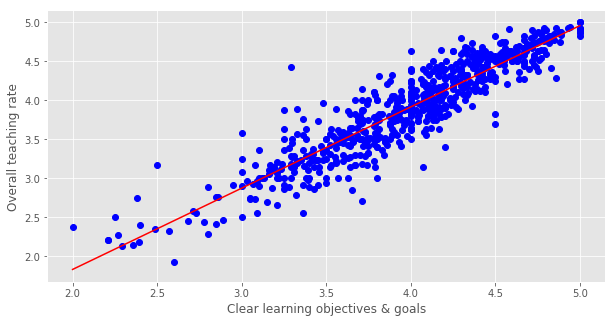

slope: 0.837861569408
intercept: 0.596719200492
r_value: 0.85114477361
p_value: 2.24534271893e-184
std_error: 0.0202525902546


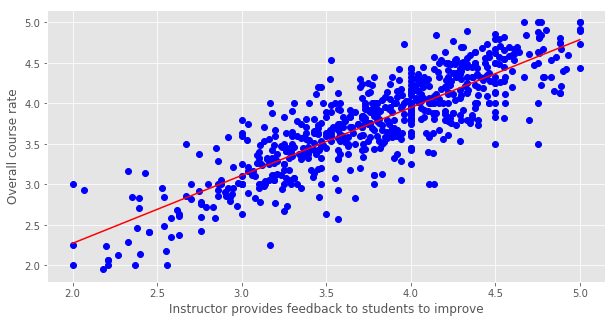

slope: 0.922928200365
intercept: 0.406403856149
r_value: 0.915784618649
p_value: 4.48552924203e-260
std_error: 0.0158654767815


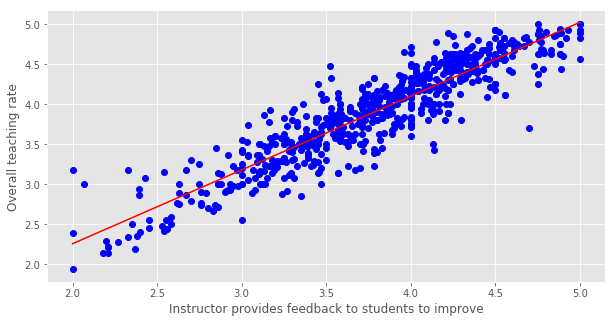

slope: 0.963915217136
intercept: -0.0312944893751
r_value: 0.911246237857
p_value: 5.47737897301e-253
std_error: 0.0170751411033


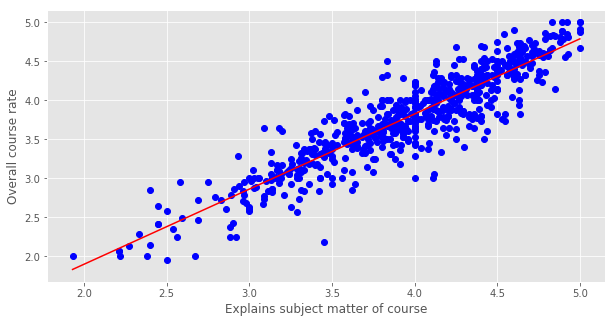

slope: 1.02704061112
intercept: -0.148594107197
r_value: 0.948372149016
p_value: 0.0
std_error: 0.0134615885203


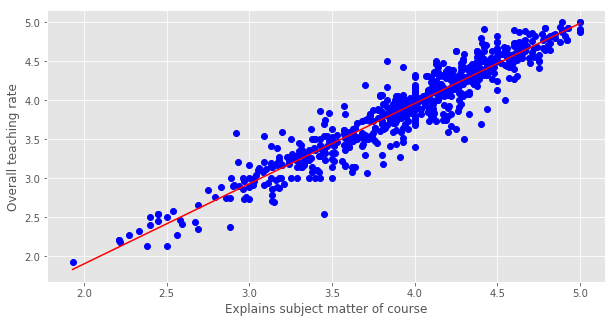

slope: 0.917959765102
intercept: -0.213646642215
r_value: 0.7436011419
p_value: 6.55146620137e-116
std_error: 0.0323500323701


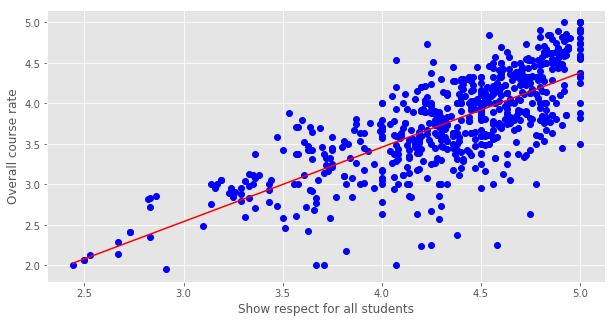

slope: 1.00863688136
intercept: -0.47531029704
r_value: 0.798078312327
p_value: 2.34323093125e-145
std_error: 0.0298465835621


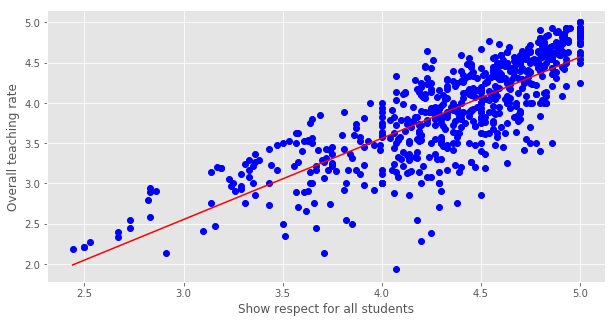

In [115]:
categories = ['Interest in student learning', 'Clearly explain course requirements', 'Clear learning objectives & goals', 'Instructor provides feedback to students to improve', 'Explains subject matter of course', 'Show respect for all students']  
overall = ["Overall course rate", "Overall teaching rate"]
for cat in categories:
    for ov in overall:
        p = plot_against_overall(category = cat, df = lowest_df, dept=None, course_level=None, overall_category=ov)
        plt.xlabel(cat)
        plt.ylabel(ov)
        plt.show()

We can also see that from the lowest rated departments, explaining the subject matter of the course has the strongest correlation to overall teaching and course rate. The professors who have received the lowest overall ratings do not explain course material well, as to be expected.

Explaining course subject matter well also holds the strongest correlation for the highest rated departments, although it is not as strongly correlated as the lowest ones. This could be a result of the greater cluster of datapoints in the higher ratings, making for a weaker correlation as the course is rated highly overall.

slope: 1.02434924743
intercept: -0.277471867991
r_value: 0.800807537232
p_value: 0.0
std_error: 0.0175067533028


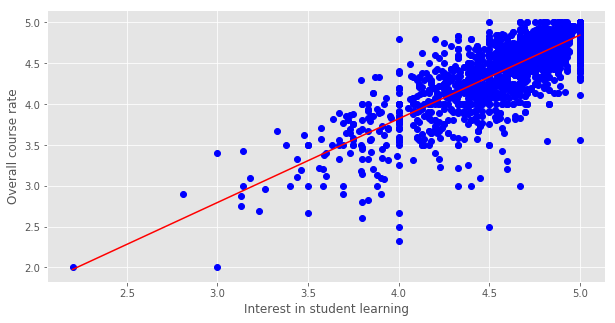

slope: 1.03767187498
intercept: -0.273698769387
r_value: 0.842327508624
p_value: 0.0
std_error: 0.0151724619125


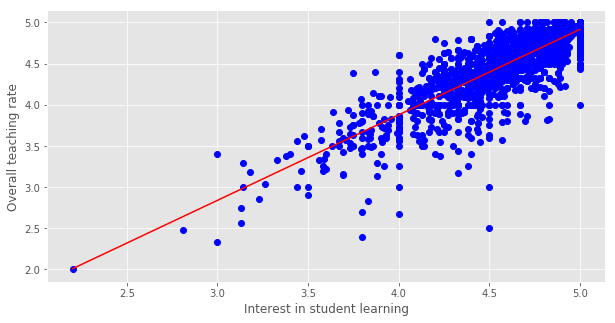

slope: 0.769523536417
intercept: 1.01765338197
r_value: 0.806041832136
p_value: 0.0
std_error: 0.0129121295913


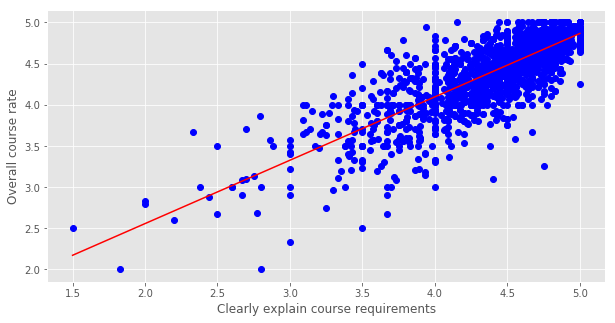

slope: 0.759428428901
intercept: 1.12713241031
r_value: 0.825968269183
p_value: 0.0
std_error: 0.0118440417856


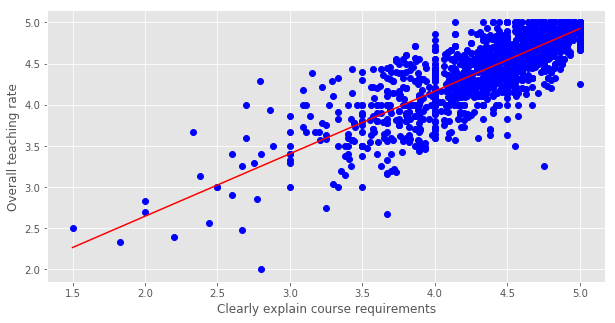

slope: 0.897703024097
intercept: 0.421177963553
r_value: 0.853658401352
p_value: 0.0
std_error: 0.0125159243549


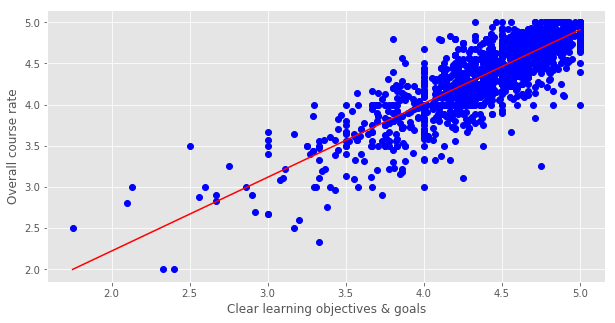

slope: 0.879242409482
intercept: 0.568249054842
r_value: 0.868162249234
p_value: 0.0
std_error: 0.0114855164932


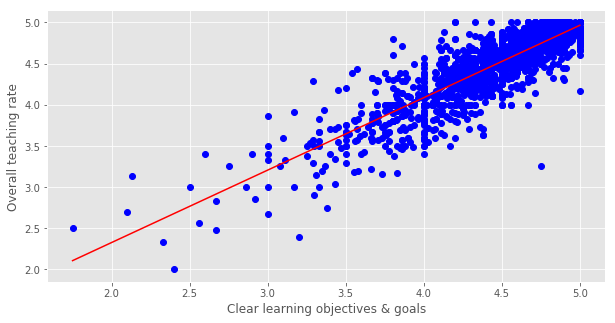

slope: 0.773965672142
intercept: 1.03167784901
r_value: 0.810908454661
p_value: 0.0
std_error: 0.0127629122959


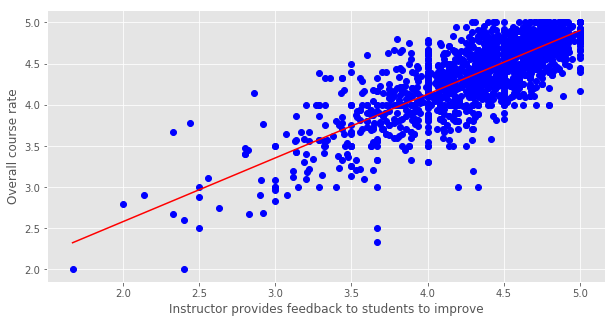

slope: 0.768296149173
intercept: 1.12134830365
r_value: 0.835833214121
p_value: 0.0
std_error: 0.0115314495007


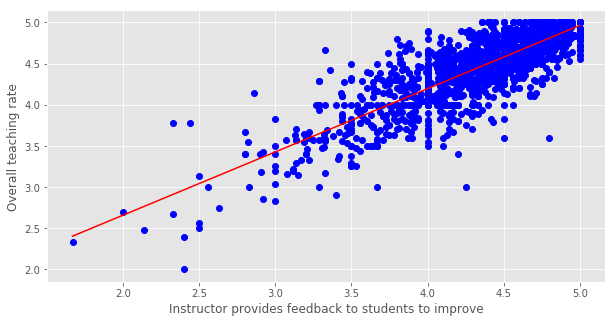

slope: 0.972295729371
intercept: 0.0497164703056
r_value: 0.875899537117
p_value: 0.0
std_error: 0.0122391478468


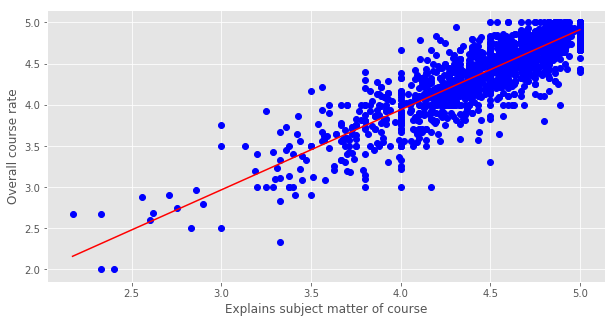

slope: 0.965634005537
intercept: 0.144510081084
r_value: 0.903252784142
p_value: 0.0
std_error: 0.01048301792


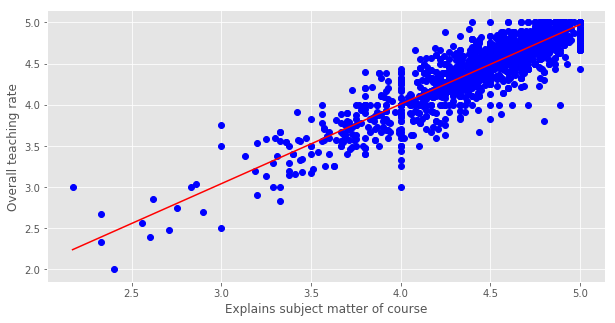

slope: 0.933963015265
intercept: 0.0505532233552
r_value: 0.665312678633
p_value: 2.30037166753e-245
std_error: 0.0239489796156


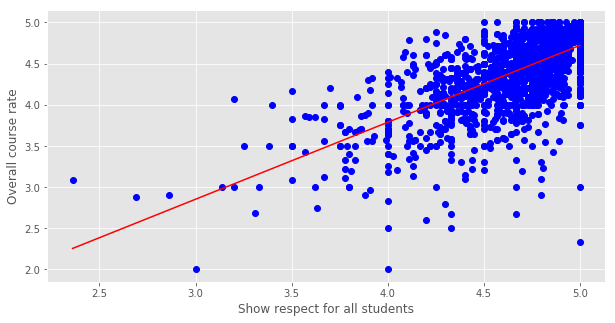

slope: 0.98266434872
intercept: -0.112387732108
r_value: 0.726845590441
p_value: 8.51634629474e-315
std_error: 0.0212182475375


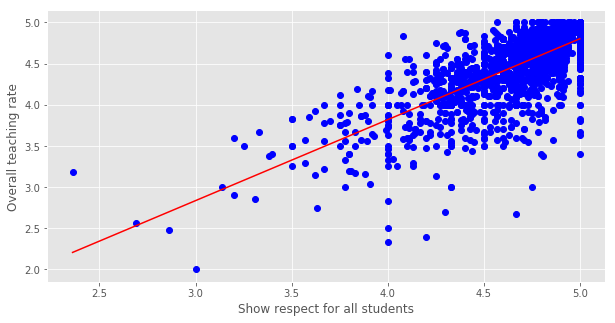

In [116]:
categories = ['Interest in student learning', 'Clearly explain course requirements', 'Clear learning objectives & goals', 'Instructor provides feedback to students to improve', 'Explains subject matter of course', 'Show respect for all students']  
overall = ["Overall course rate", "Overall teaching rate"]
for cat in categories:
    for ov in overall:
        p = plot_against_overall(category = cat, df = highest_df, dept=None, course_level=None, overall_category=ov)
        plt.xlabel(cat)
        plt.ylabel(ov)
        plt.show()

## Adjustment by Levels (RIP Aviicii)

We can also compared the differences across different course levels. Typically the undergraduate level classes range from numbers in the 100-400 while the graduate classes range from 500-900, although the 900-level courses should be taken with a grain of salt since there are so few of them. For our purposes, they are outliers in our dataset.

In [25]:
lvl100 = df[list(map(lambda x: str(x)[-3] == '1', df['Num']))]
lvl200 = df[list(map(lambda x: str(x)[-3] == '2', df['Num']))]
lvl300 = df[list(map(lambda x: str(x)[-3] == '3', df['Num']))]
lvl400 = df[list(map(lambda x: str(x)[-3] == '4', df['Num']))]
lvl500 = df[list(map(lambda x: str(x)[-3] == '5', df['Num']))]
lvl600 = df[list(map(lambda x: str(x)[-3] == '6', df['Num']))]
lvl700 = df[list(map(lambda x: str(x)[-3] == '7', df['Num']))]
lvl800 = df[list(map(lambda x: str(x)[-3] == '8', df['Num']))]
lvl900 = df[list(map(lambda x: str(x)[-3] == '9', df['Num']))]
level_list = [lvl100, lvl200, lvl300, lvl400, lvl500, lvl600, lvl700, lvl800, lvl900]

100
4.113427230046947


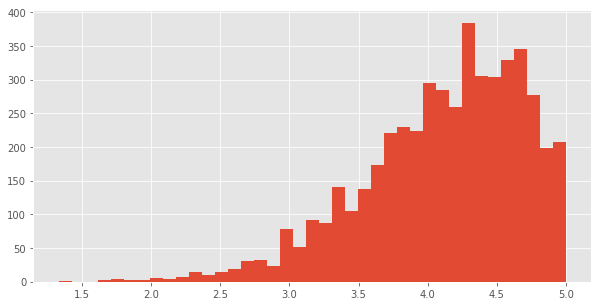

200
4.082226890756302


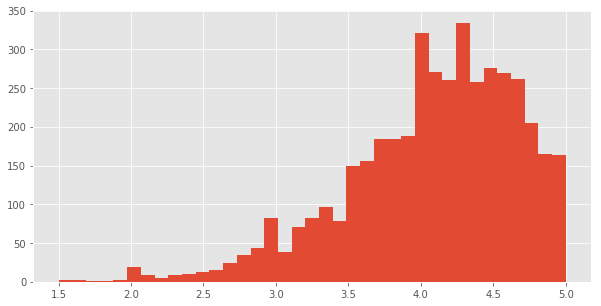

300
4.101535422702133


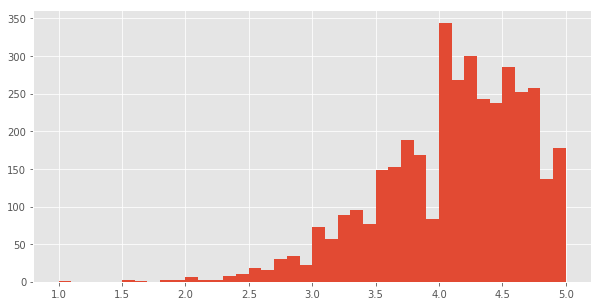

400
4.052660256410257


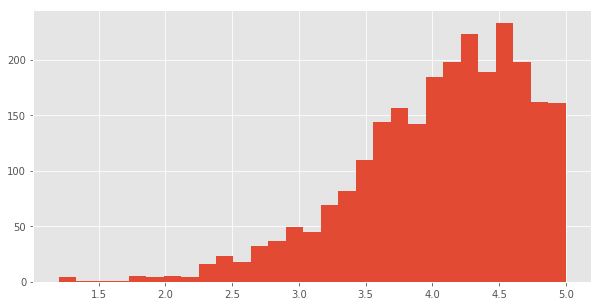

500
4.203267326732673


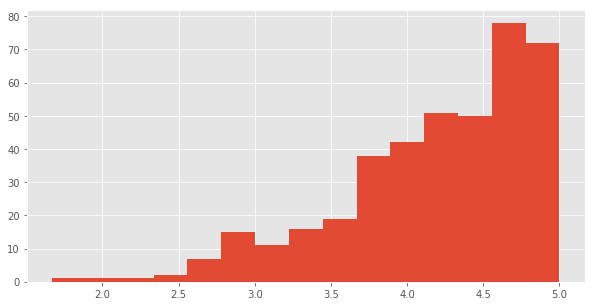

600
4.1567009867009865


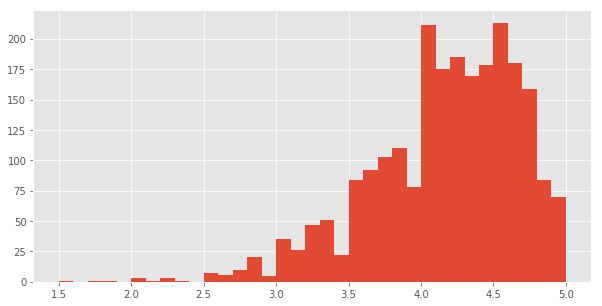

700
4.176415753903519


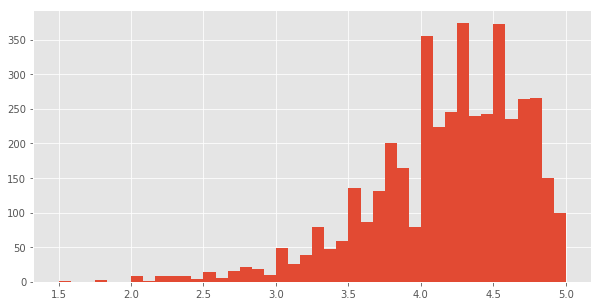

800
4.208110709987967


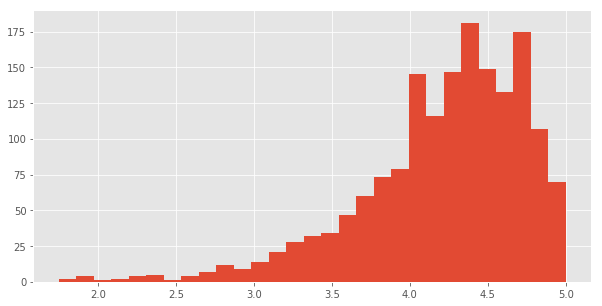

900
4.358501872659176


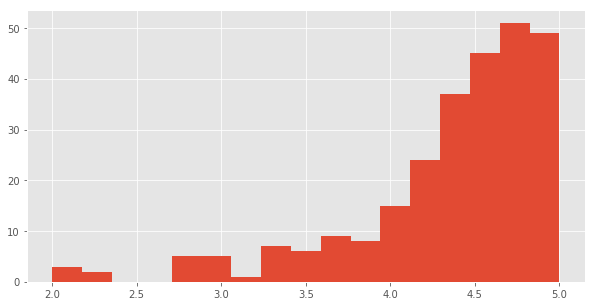

In [29]:
for i in range(len(level_list)):
    print((i+1)*100)
    level = level_list[i]
    print(level['Overall course rate'].mean())
    plt.hist(level['Overall course rate'][~np.isnan(level['Overall course rate'])], bins='auto')
    plt.show()

We can clearly see the increase in overall course rate as the course level increases. We can confirm this data using a scatterplot to display the mean overall course rate per level.

In [30]:
levels = np.array(list(range(100, 1000, 100)))
course_rate_values = np.array([lvl100['Overall course rate'].mean(), lvl200['Overall course rate'].mean(), lvl300['Overall course rate'].mean(), lvl400['Overall course rate'].mean(), lvl500['Overall course rate'].mean(), lvl600['Overall course rate'].mean(), lvl700['Overall course rate'].mean(), lvl800['Overall course rate'].mean(), lvl900['Overall course rate'].mean()])
teaching_rate_values = np.array([lvl100['Overall teaching rate'].mean(), lvl200['Overall teaching rate'].mean(), lvl300['Overall teaching rate'].mean(), lvl400['Overall teaching rate'].mean(), lvl500['Overall teaching rate'].mean(), lvl600['Overall teaching rate'].mean(), lvl700['Overall teaching rate'].mean(), lvl800['Overall teaching rate'].mean(), lvl900['Overall teaching rate'].mean()])

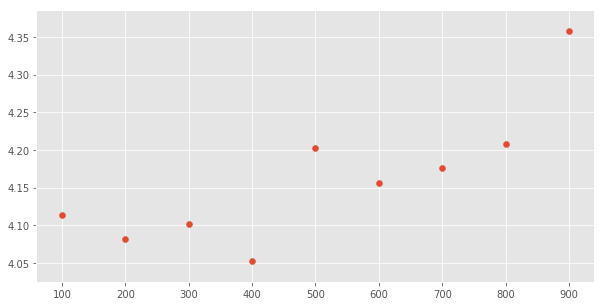

In [31]:
plt.scatter(levels, course_rate_values)
plt.show()

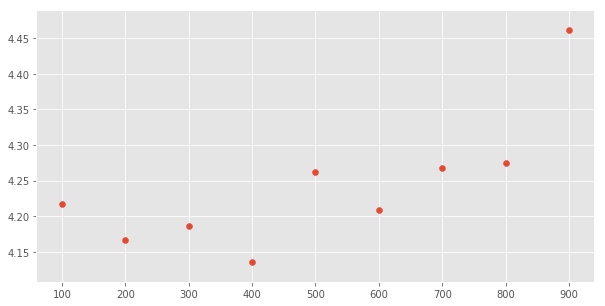

In [32]:
plt.scatter(levels, teaching_rate_values)
plt.show()

There appears to be a separation between the undergraduate and graduate satisfaction level with their courses. Undergraduates are certainly not as satisfied with their courses as graduate students are. This trend can be useful in prompting administrators to identify problems with undergraduate courses and work towards making improvements in those courses.

In [34]:
df.head()

,Year,Semester,Dept,Num,Section,Name,Course Name,Level,Possible Respondents,Num Respondents,...,Hrs Per Week,Interest in student learning,Clearly explain course requirements,Clear learning objectives & goals,Instructor provides feedback to students to improve,Demonstrate importance of subject matter,Explains subject matter of course,Show respect for all students,Overall teaching rate,Overall course rate
1,2018,Spring,ARC,48733,A3,"KARAGUZEL, OMER",ENV PERF SIM,Graduate,12,9,...,8.00,4.56,4.67,4.67,4.44,4.89,4.67,4.89,4.67,4.44
2,2018,Spring,ART,60131,C3,"BINGHAM, ROBERT",3D MEDIA STUDIO II,Undergraduate,14,4,...,10.25,5.00,3.50,4.00,5.00,4.50,4.50,5.00,4.75,4.50
3,2018,Spring,ART,60131,D3,"GURYSH, STEVEN",3D MEDIA STUDIO II,Undergraduate,13,3,...,8.00,5.00,5.00,5.00,4.67,5.00,4.67,5.00,5.00,4.67
4,2018,Spring,ART,60131,A3,"SCARPONE, PHILLIP",3D MEDIA STUDIO II,Undergraduate,12,5,...,12.20,4.80,4.80,4.80,4.80,4.80,5.00,4.60,4.80,4.80
11,2018,Spring,CHE,6462,A3,"GOUNARIS, CHRYSANTHOS",OPTM MDG & ALGRTHMS,Undergraduate,86,23,...,7.87,4.57,4.22,4.35,3.91,4.30,4.13,4.57,4.22,4.04


## By Experience

Another one of our queries involved determining the relationship between course quality and the number of times a professor has taught the same course. We decided to investigate further as to how many semesters on average a professor has taught a course and how their semesters of experience relates to their overall course rating.

In [35]:
df['Academic Semester'] = df["Semester"].map(str) + ' ' + df["Year"].map(str)
experience_df = df.drop(labels = ['Year', 'Semester', 'Academic Semester'], axis = 1)
experience_df = experience_df.groupby(['Num', 'Name']).agg(['mean', 'count', 'first', 'last'])
experience_df

Possible Respondents                   \
                                            mean count first last   
Num   Name                                                          
2201  KINGSFORD, CARLETON              17.000000     1    17   17   
2223  KIM, SE YOUNG                    17.500000     2    11   24   
2250  ILYIN, VALENTIN                  23.000000     1    23   23   
      MURPHY, ROBERT                   13.666667     3    14   16   
      SCHWARTZ, RUSSELL                13.666667     3    14   16   
2252  MURPHY, ROBERT                   11.000000     1    11   11   
2261  KANGAS, JOSHUA                   11.000000     1    11   11   
      THICKMAN, KAREN                  21.000000     1    21   21   
2601  COMPEAU, PHILLIP                 24.333333     3    26   24   
      KINGSFORD, CARLETON              39.000000     1    39   39   
2602  COMPEAU, PHILLIP                 26.000000     1    26   26   
      SUBRAMANIAN, SHOBA               20.000000     2    26   14   
      THICKMAN, KAREN                  14.000000     1    14   14   
2604  COMPEAU, PHILLIP                 30.000000     1    30   30   
2613  KINGSFORD, CARLETON              63.500000     2    69   58   
      MA, JIAN                         35.000000     2    28   42   
2651  VU, DU (JOHN)                    30.000000     6    27   17   
2652  NAIK, ARMAGHAN                   28.000000     1    28   28   
      THICKMAN, KAREN                  23.000000     1    23   23   
      VU, DU (JOHN)                    17.500000     2    14   21   
2654  VU, DU (JOHN)                    26.800000     5    32   16   
2710  BAR-JOSEPH, ZIV                  13.666667     3    15   15   
      KIM, SE YOUNG                    30.000000     1    30   30   
      MA, JIAN                         31.000000     1    31   31   
2711  DURAND, M                        14.000000     3    15   12   
2712  SCHWARTZ, RUSSELL                16.000000     5    17   11   
2713  KINGSFORD, CARLETON              67.000000     2    76   58   
2717  BAR-JOSEPH, ZIV                  12.000000     1    12   12   
2718  LANGMEAD, CHRISTOPHER            12.000000     1    12   12   
      WU, WEI                          12.000000     1    12   12   
...                                          ...   ...   ...  ...   
99275 MANKE, KODY                      19.000000     3    18   18   
99333 NAIR, INDIRA                     44.000000     1    44   44   
99334 NAIR, INDIRA                     36.000000     1    36   36   
99339 NAIR, INDIRA                     15.000000     1    15   15   
99340 NAIR, INDIRA                     18.000000     1    18   18   
99352 FINGER, SUSAN                    11.000000     1    11   11   
      LIU, Jennifer                    11.000000     1    11   11   
      ROBINSON, OLIVIA                 17.000000     1    17   17   
99353 FINGER, SUSAN                    22.000000     3    29   21   
      KNOPF, JAMES                     16.000000     1    16   16   
      TOURETZKY, DAVID                 17.000000     1    17   17   
99355 ZACHARIAS, ROBERT                12.400000     5    13   13   
      ZEGLIN, GARTH                    12.666667     3    14   11   
99358 CORBETT, THOMAS                  12.000000     1    12   12   
      DYAR, HUGH                       14.000000     1    14   14   
99359 LARSON, ELIZABETH                13.000000     2    11   15   
99405 CHEEK, ALEXANDER                 19.000000     1    19   19   
      PATTERSON, GARY                  19.000000     1    19   19   
      helenz, Vincent                  16.500000     2    17   16   
99410 LIMAM MANSAR, SELMA              16.000000     1    16   16   
99451 CARVALHO, SARAH                  11.000000     1    11   11   
      COSTELLO, CARA                   14.500000     2    15   14   
99452 HEIDISH, PEGGY                   13.363636    11    11   12   
99461 HALLINEN, JUDITH                 13.000000     1    13   13   
99522 MADSEN, PETER       

2.8012769353551477


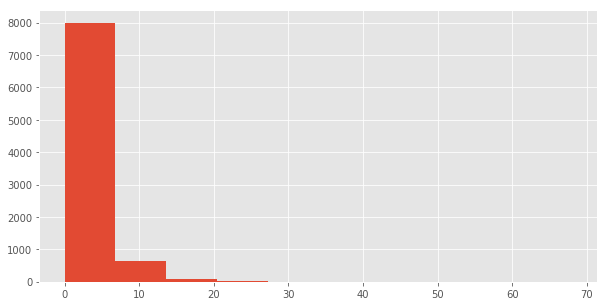

In [36]:
plt.hist(experience_df['Overall course rate']['count'])
print(experience_df['Overall course rate']['count'].mean())
plt.show()

On average, a professor teaches one course for 2.8 semesters. Most professors teach the same course for at most 6 semesters.

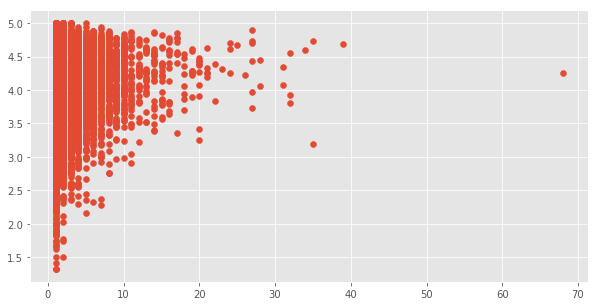

In [45]:
plt.scatter(experience_df['Overall course rate']['count'],experience_df['Overall course rate']['mean'] )

From the graph above, we can see that the professors who have taught the same course repeatedly often receive higher average course rates than those who teach the same course less frequently. This aligns with our line of thought as we'd like to believe that professors with more time in a course will often standardize their method of teaching and improve with each subsequent semester while maintaining their course quality.

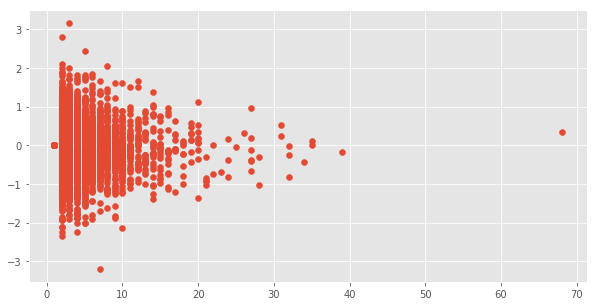

In [37]:
plt.scatter(experience_df['Overall course rate']['count'],experience_df['Overall course rate']['last'] - experience_df['Overall course rate']['first'] )

Likewise we can see that over the semesters, the more times a professor teaches a course, the less their fluctuation in overall course rating. Only professors who have taught a course twice or thrice can expect high changes in overall course rating from the first time they taught it to the last. Again, a professor who has gained experience teaching the same course maintains his/her overall quality.

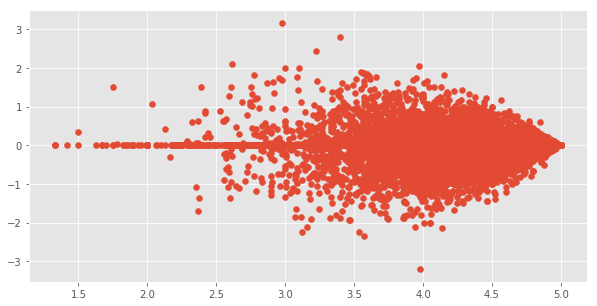

In [38]:
plt.scatter(experience_df['Overall course rate']['mean'],experience_df['Overall course rate']['last'] - experience_df['Overall course rate']['first'] )

In [117]:
experience_df['Experience'] = experience_df['Possible Respondents']['count']
experience_df
by_years = experience_df.groupby(['Experience']).agg(['mean', 'count'])

Lastly, we can see that indeed the overall course rate and teaching rate increases the more times a professor has taught of course. This affirms that they are improving themselves, while maintaining their course quality.

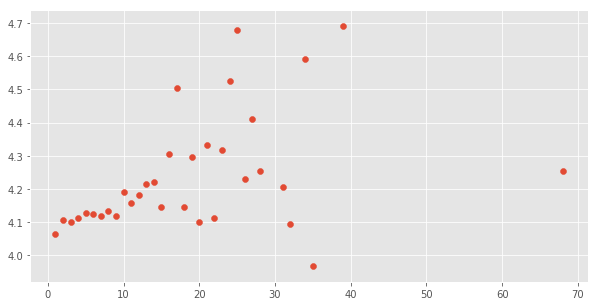

In [40]:
plt.scatter(by_years.index, by_years['Overall course rate']['mean']['mean'])

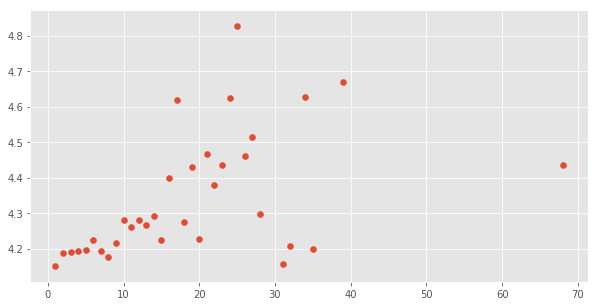

In [41]:
plt.scatter(by_years.index, by_years['Overall teaching rate']['mean']['mean'])

## Impact on Time Spent and Evaluations

Finally, we hope to investigate the possible relationship between time spent on a course and overall course and teaching rates.

slope: 0.00691649158218
intercept: 4.10995805963
r_value: 0.052499859374
p_value: 1.52328822127e-08
std_error: 0.00122135870265


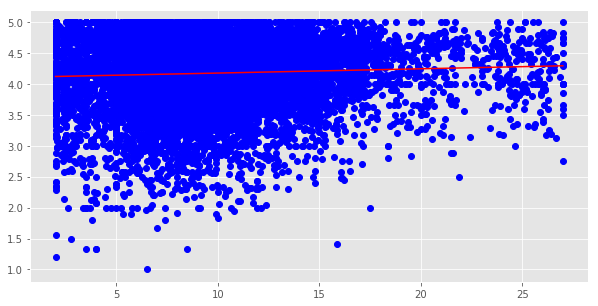

In [14]:
plot_against_overall(category='Hrs Per Week', df = df, dept=None, course_level=None, overall_category="Overall course rate")

slope: 0.0330879927068
intercept: 3.74580201374
r_value: 0.134917323513
p_value: 0.00786729857751
std_error: 0.012384636373


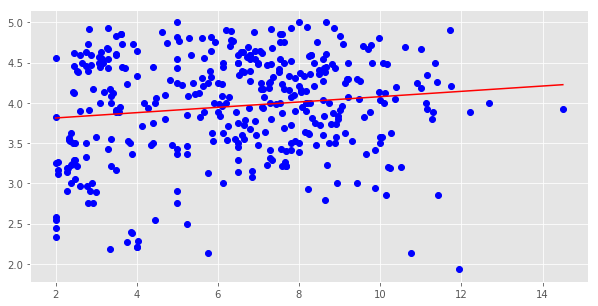

In [121]:
plot_against_overall(category='Hrs Per Week', df = lowest_df, course_level=None, overall_category="Overall teaching rate")

slope: -0.00887063973869
intercept: 4.60837059099
r_value: -0.1014182073
p_value: 0.00128442992647
std_error: 0.00274753655095


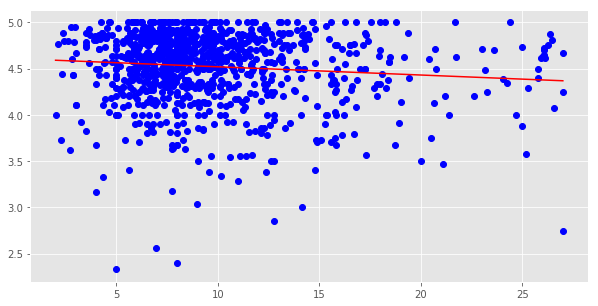

In [122]:
plot_against_overall(category='Hrs Per Week', df = highest_df, course_level=None, overall_category="Overall teaching rate")

Interestingly, amongst the highest rated departments, the time spent on the course is negatively correlated with course and teaching rating, while the lowest rated departments have a positive correlation between hours per week and ratings.

100
slope: 0.009856458528472804
intercept: 4.081291208674814
r_value: 0.07883309916316907
p_value: 0.00045376876194863224
std_error: 0.0028060477010485602


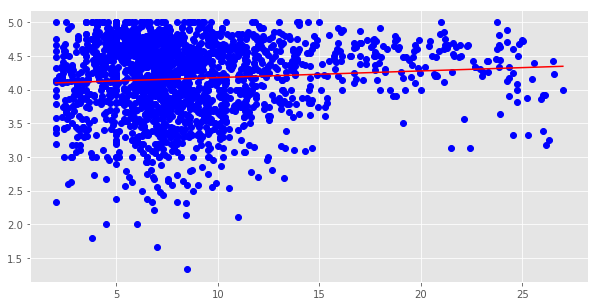

200
slope: 0.011111673177021799
intercept: 4.048653383292721
r_value: 0.07913551290536905
p_value: 0.0008645031384440426
std_error: 0.0033298572647383656


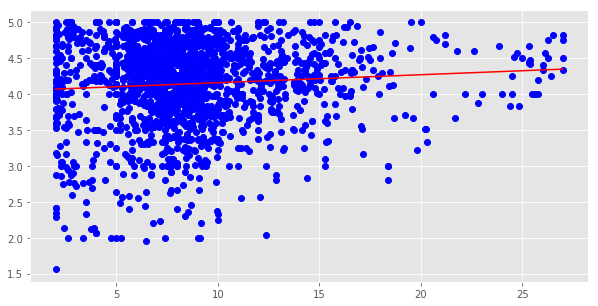

300
slope: -0.007432532973164231
intercept: 4.2202081328731325
r_value: -0.05006358865391719
p_value: 0.05062223697746968
std_error: 0.0037994434281488935


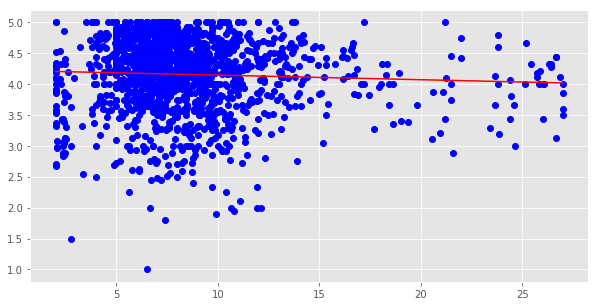

400
slope: 0.008440473084774662
intercept: 3.9846416034424443
r_value: 0.05115576045079217
p_value: 0.10317821365054276
std_error: 0.00517468915581538


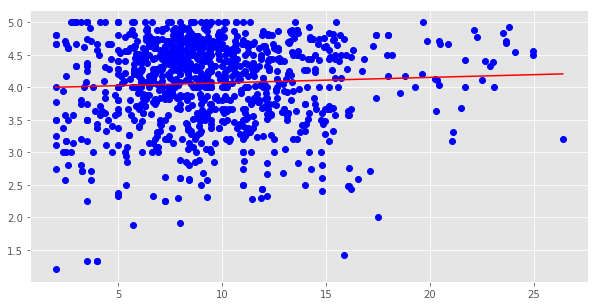

500
slope: -0.000679771210739244
intercept: 4.355553579003373
r_value: -0.006964441049074135
p_value: 0.935385914154266
std_error: 0.008369442195434153


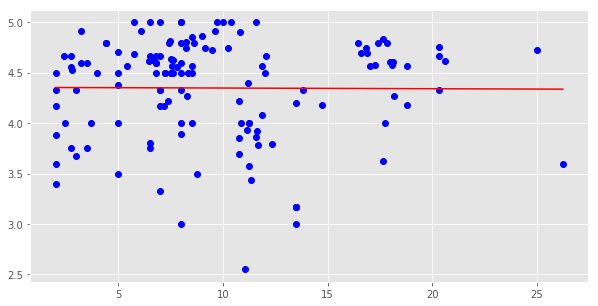

600
slope: 0.00022307499648888845
intercept: 4.194861698910061
r_value: 0.002226662566972374
p_value: 0.9379950890632708
std_error: 0.002867065257596517


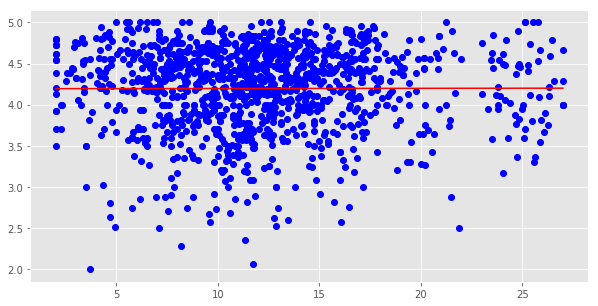

700
slope: 0.005693864343626339
intercept: 4.145957049160532
r_value: 0.03878788561173197
p_value: 0.050536903663187666
std_error: 0.0029104973442223244


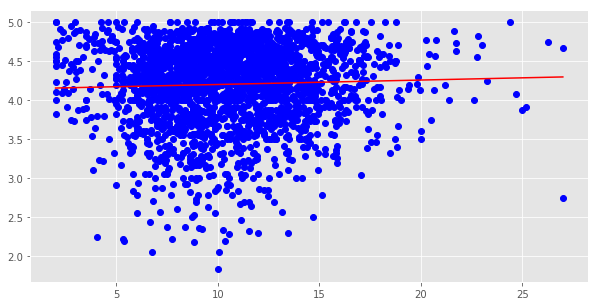

800
slope: 0.02167531248494699
intercept: 3.999318398738313
r_value: 0.12532321435976174
p_value: 1.9751945111121906e-05
std_error: 0.005057764679358452


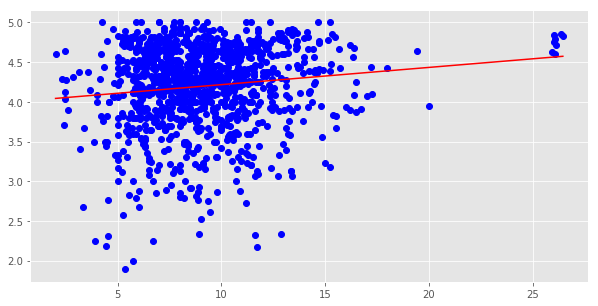

900
slope: 0.014875805133335558
intercept: 4.275901459877124
r_value: 0.1402442959936806
p_value: 0.046511050362556774
std_error: 0.007426202084431165


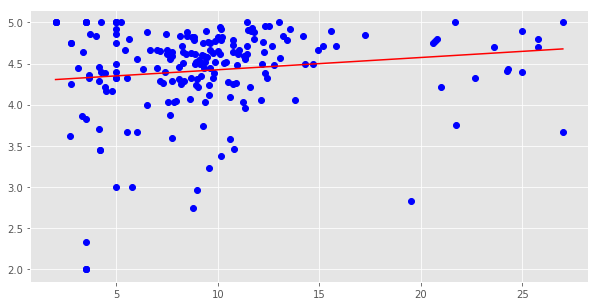

In [49]:
for i in range(len(level_list)):
    print((i+1)*100)
    level = level_list[i]
    plot_against_overall(category='Hrs Per Week', df = level, dept=None, course_level=None, overall_category="Overall course rate")
    plt.show()

100
slope: -0.0035849380609444645
intercept: 4.303635181467459
r_value: -0.02900861708094338
p_value: 0.1975280892135819
std_error: 0.002781046703688541


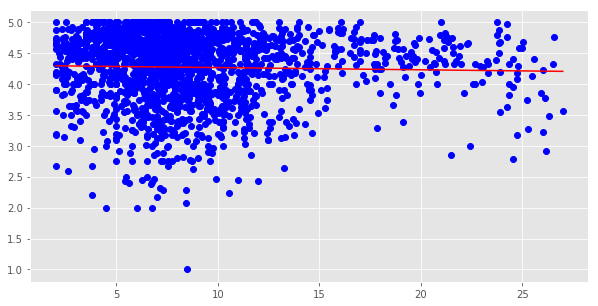

200
slope: 0.0024269816412843693
intercept: 4.193784569173633
r_value: 0.017211235497428767
p_value: 0.469411111220828
std_error: 0.003354067782882911


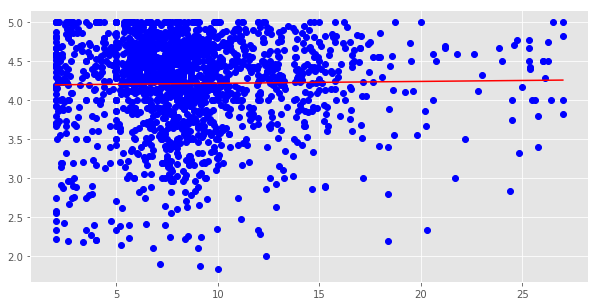

300
slope: -0.004490476868676795
intercept: 4.273640127128539
r_value: -0.03129283374562237
p_value: 0.22196439939985407
std_error: 0.003675232982875895


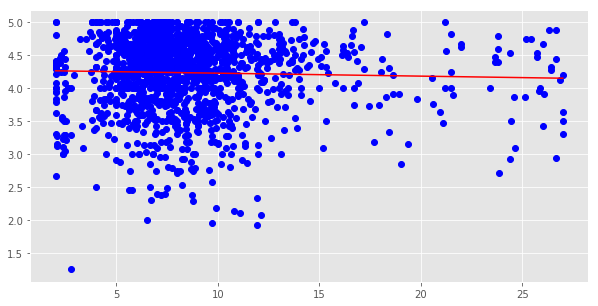

400
slope: 0.007146045869089209
intercept: 4.095620835631592
r_value: 0.04632649383665152
p_value: 0.14004589198417952
std_error: 0.0048389469350658834


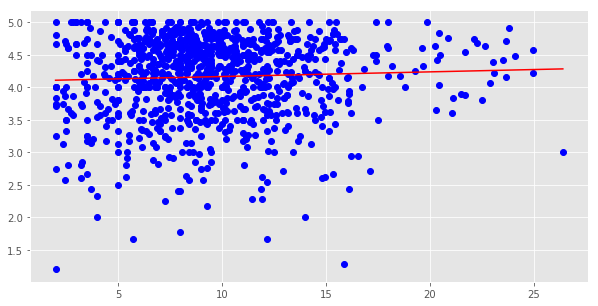

500
slope: 0.0009325487248086515
intercept: 4.370799101254033
r_value: 0.009843152730523256
p_value: 0.9087765568881765
std_error: 0.008123567895987286


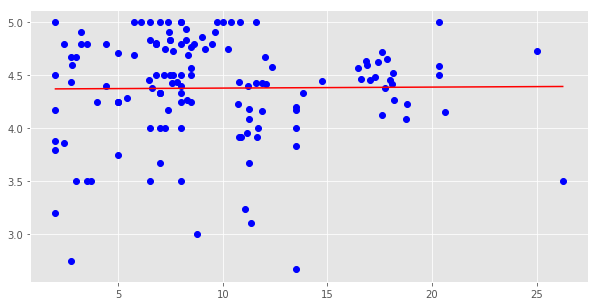

600
slope: -0.00836492423368162
intercept: 4.351422391467249
r_value: -0.08397601229345938
p_value: 0.0032932669997600824
std_error: 0.0028406137898424545


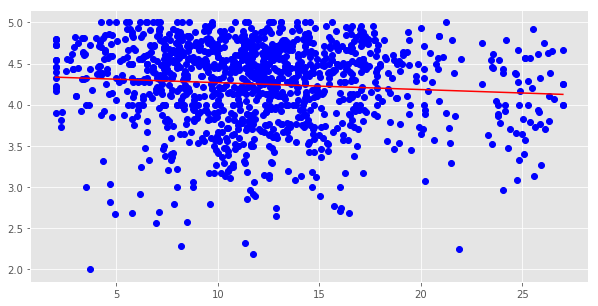

700
slope: -0.006194466001040618
intercept: 4.359506156136548
r_value: -0.043161922839919396
p_value: 0.029548353649112503
std_error: 0.002844993766708734


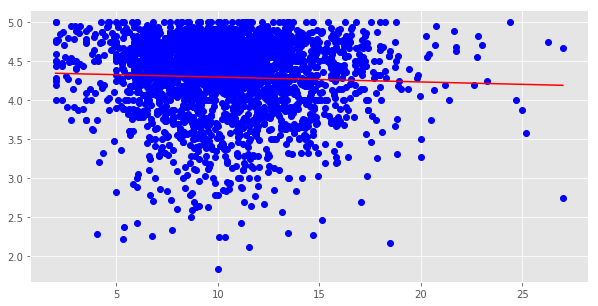

800
slope: 0.014769586366778874
intercept: 4.134141577642804
r_value: 0.08934904881609544
p_value: 0.002391772350567804
std_error: 0.004852887677576589


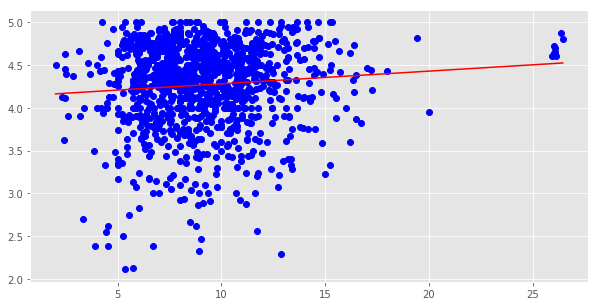

900
slope: 0.006302927683984729
intercept: 4.446410756852003
r_value: 0.06463229227189336
p_value: 0.36200063677394057
std_error: 0.006898540698320528


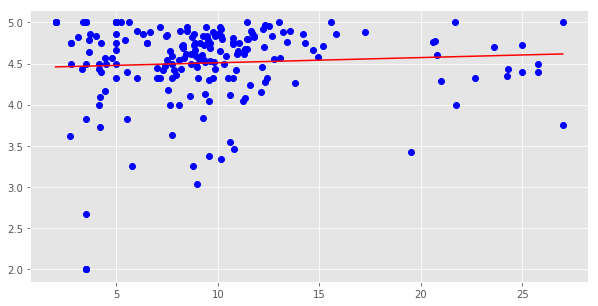

In [50]:
for i in range(len(level_list)):
    print((i+1)*100)
    level = level_list[i]
    plot_against_overall(category='Hrs Per Week', df = level, dept=None, course_level=None, overall_category="Overall teaching rate")
    plt.show()

There's almost no correlation between hours spent on a course and its overall rating between department levels. However it's interesting to note the amount of hours students typically spend on courses. I supposed students are willing to spend any amount of time on a course so long as they work towards the grade they hope to achieve. Such is CMU.

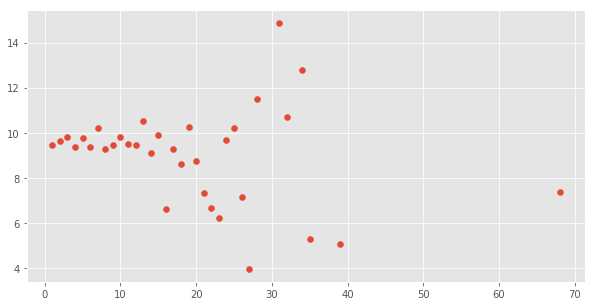

In [53]:
plt.scatter(by_years.index, by_years['Hrs Per Week']['mean']['mean'])
plt.show()

Furthermore, it appears that there is no significant relationship between how long a professor has been teaching a class and the mean number of hours of week of courses they teach. 

## Multiple Professors vs One
In addition to the other metrics, we also wanted to explore the impact of having multiple professors teach a class rather than just one. This is sometimes because each professor teaches a different section of the class, and other times because each of the professors teaches a different combination of topics. 

Mean number of professors: 1.4734348764691774
Median number of professors: 1.0
3.0


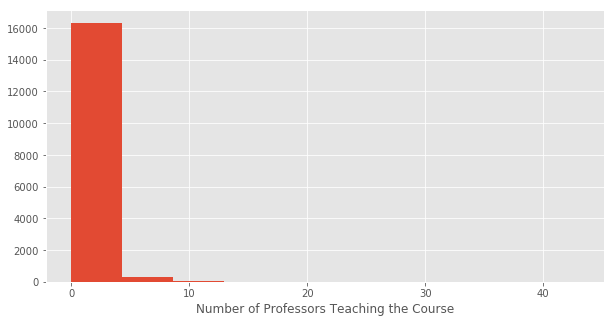

In [161]:
by_num_professors = df.groupby(['Year', 'Semester', 'Num']).agg(['min', 'max', 'mean', 'count'])
num_professors = by_num_professors['Overall course rate']['count']
print("Mean number of professors: " + str(by_num_professors['Overall course rate']['count'].mean()))
print("Median number of professors: " + str(by_num_professors['Overall course rate']['count'].median()))
print(np.percentile(by_num_professors['Overall course rate']['count'], 95))
plt.hist(num_professors)
plt.xlabel('Number of Professors Teaching the Course')
plt.show()

As we see from the distribution above, the median number of professors per course is 1, with only a 5% of courses having 3 or more professors. 

In [140]:
by_num_professors[num_professors >= 15]

Possible Respondents                        \
                                     min  max       mean count   
Year Semester Num                                                
2008 Spring   15100                   15   48  27.333333    15   
2009 Fall     15110                   16  119  29.200000    20   
     Spring   15100                   17   43  28.200000    15   
2010 Fall     76101                   17   20  18.550000    20   
              99101                   15   20  18.652174    23   
     Spring   76101                   13   24  20.187500    16   
2011 Fall     76101                   17   20  18.629630    27   
     Spring   76101                   15   20  18.176471    17   
2012 Fall     76101                   16   20  18.652174    23   
     Spring   76101                   14   20  17.771429    35   
2013 Fall     76101                   14   19  18.160000    25   
     Spring   76101                   13   19  17.689655    29   
2014 Fall     76100                   12   16  15.000000    17   
              76101                   17   20  18.807692    26   
     Spring   76101                   11   20  17.371429    35   
2015 Fall     38101                   14  199  25.941176    17   
              76100                   11   16  13.812500    16   
              76101                   17   20  18.756757    37   
              95702                   13   58  23.066667    30   
     Spring   76101                   12   20  17.580645    31   
2016 Fall     38101                   14  226  40.666667    18   
              76101                   13   20  18.305556    36   
     Spring   76101                   11   20  17.511628    43   
2017 Fall     38101                   13  248  29.526316    19   
              76100                   11   17  14.562500    16   
              76101                   12   20  18.589744    39   
     Spring   76101                   12   20  17.666667    36   

                    Num Respondents                       Response Rate %  \
                                min  max       mean count             min   
Year Semester Num                                                           
2008 Spring   15100               5   28  12.333333    15           27.78   
2009 Fall     15110               8   65  18.500000    20           37.50   
     Spring   15100               7   26  16.466667    15           31.82   
2010 Fall     76101               6   19   9.800000    20           31.58   
              99101               4   11   6.173913    23           21.05   
     Spring   76101               3   16  10.687500    16           23.08   
2011 Fall     76101               8   20  14.666667    27           44.44   
     Spring   76101               6   15  10.764706    17           40.00   
2012 Fall     76101              10   18  14.173913    23           52.63   
     Spring   76101               5   19  12.028571    35           27.78   
2013 Fall     76101              10   19  14.960000    25           55.56   
     Spring   76101               6   19  13.310345    29           31.58   
2014 Fall     76100               8   15  11.764706    17           53.33   
              76101               8   19  13.307692    26           42.11   
     Spring   76101               5   19  13.514286    35           27.78   
2015 Fall     38101               7  140  18.529412    17           46.67   
              76100               9   15  12.125000    16           56.25   
              76101              10   19  15.108108    37           52.63   
              95702               6   42  14.933333    30           40.00   
     Spring   76101               4   19  13.193548    31           22.22   
2016 Fall     38101               7  137  25.111111    18           38.89   
              76101               6   19  14.222222    36           37.50   
     Spring   76101               7   20  13.651163    43           41.18   
2017 Fall     38101              11  

As we see above, the majority of classes that have 15 or more instructors are the ones that have a seperate instructor for each section, such as Interp (76-101) and Eureka (MCS intro class).

In order to get a sense of how having multiple professors at once affects the course, we will further restrict our dataset to only courses where multiple professors are teaching the same section. 

Mean number of professors: 1.1285077848711706
Median number of professors: 1.0
43


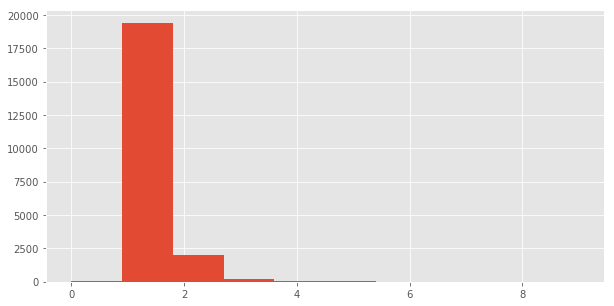

In [168]:
by_num_professors_simultaneous = df.groupby(['Year', 'Semester', 'Num', 'Section']).agg(['min', 'max', 'mean', 'count'])
print("Mean number of professors: " + str(by_num_professors_simultaneous['Overall course rate']['count'].mean()))
print("Median number of professors: " + str(by_num_professors_simultaneous['Overall course rate']['count'].median()))
plt.hist(by_num_professors_simultaneous['Overall teaching rate']['count'])
plt.show()
one_prof = by_num_professors_simultaneous[by_num_professors_simultaneous['Overall teaching rate']['count'] == 1]
multi_prof = by_num_professors_simultaneous[by_num_professors_simultaneous['Overall teaching rate']['count'] > 1]

The median number of professors per course is still 1, however, the number of instructors is much lower, which seems a lot more reasonable. 

Mean Course Rate, One Professor: 4.157095510540689
Mean Course Rate, Multiple Professors: 4.023900761319392


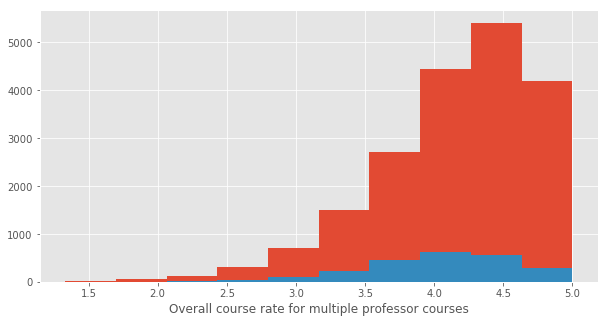

In [160]:
print("Mean Course Rate, One Professor: " + str(one_prof["Overall course rate"]["mean"].mean()))
print("Mean Course Rate, Multiple Professors: " + str(multi_prof["Overall course rate"]["mean"].mean()))

plt.hist(one_prof["Overall course rate"]["mean"])
plt.xlabel("Overall course rate for single professor courses")
plt.hist(multi_prof["Overall course rate"]["mean"])
plt.xlabel("Overall course rate for multiple professor courses")
plt.show()

As we can see, courses taught by only one professor fair better than courses with multiple professors, although the distributions of both are quite similar. 

Difference in teaching rate between professors: 0.241


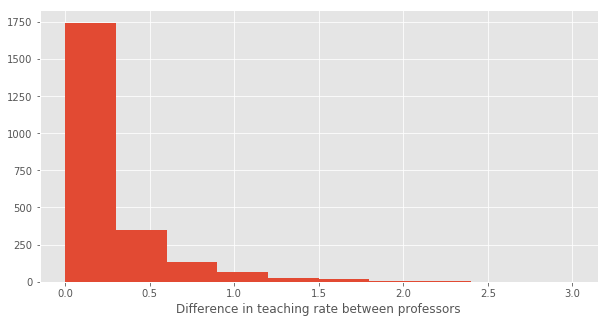

In [158]:
teaching_rate_diff = (multi_prof["Overall teaching rate"]['max']-multi_prof["Overall teaching rate"]['min'])
print("Difference in teaching rate between professors: " + str(round(course_rate_diff.mean(), 3)))
plt.hist(course_rate_diff)
plt.xlabel("Difference in teaching rate between professors")
plt.show()

The overall difference between teaching rates within classes with multiple professors is on average 0.241. The distribution is skewed heavily on the low end, but in some courses the teaching difference goes up as high as 2.0. 

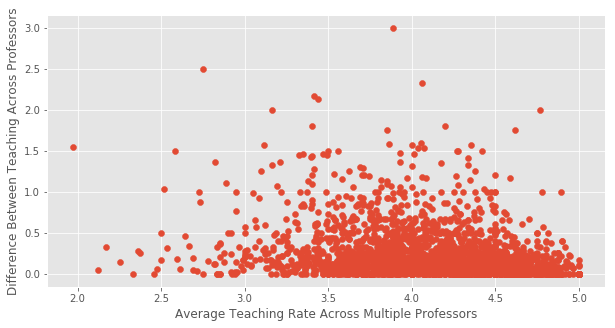

In [159]:
plt.scatter(multi_prof["Overall teaching rate"]['mean'], course_rate_diff)
plt.xlabel("Average Teaching Rate Across Multiple Professors")
plt.ylabel("Difference Between Teaching Across Professors")
plt.show()

There appears to be no correlation between the average course rate and the variance amongst the rating for courses with multiple professors.

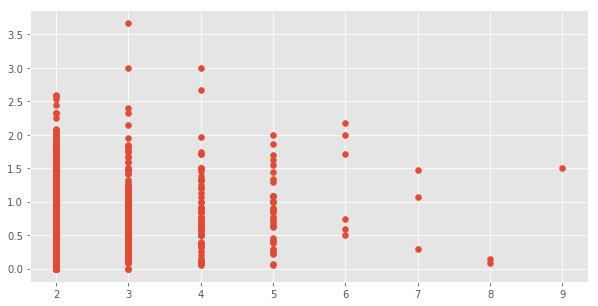

In [162]:
plt.scatter(multi_prof["Overall teaching rate"]['count'], teaching_rate_diff)

Lastly, an interesting relationship is evident as the number of professors for a class increases, the overall variation in their teaching seems to decrease, but this is also possibly due to the low number of courses with that many instructors. 

## Conclusion
We are able to gain a lot of insight into courses at CMU by mining the data collected by FCE. In summary:

### 1. Across Different Categories


The relationship between different categories on the FCE data have strong correlations to the overall score given to the course. However, of the categories, 'shows respect to the students' has the weakest relationship to the overall course and teaching ratings. 


### 2. Impact of Professor's Experience with a Course

The more years that a professor has taught a course generally correlates with the overall rating of the course. Moreover, the more often a professor has taught a course, the smaller the variation in the course rating becomes. 


### 3. Variation Across Departments and Course Levels
The highest rated departments at CMU in terms of course rate are all graduate level courses. This is further evidenced by the fact that graduate levels (500-900) are all much higher rated than undergraduate courses. 


### 4. Impact of Time Spent on Course Rating

For low rated departments, an increase in time spent is correlated with higher ratings, while the opposite is true for highly rated departments, but overall, there does not seem to be a serious correlation between the two. 


### 5. Multiple Professors vs. One Professor 

The average course rate for courses taught by a single professor is 4.16, while it is 4.02 for courses with multiple professors. The average disparity in the teaching rate between two professors in the same course is 0.241, with the largest difference being as high as 3.0. 

## Thank you for reading!